<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center"> 📊Stacking_ XGB & LGB  📚</p>

# Introduction

In this notebook, we are going to use the  **Stacking Ensemble Machine Learning** method. Stacking or Stacked Generalization is an ensemble machine learning algorithm.

It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.

The benefit of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble.

Thank you @Rudolph. I used his notebook to study. I made more detailed about it and plus description about the models it use. 




### **After studying this notebook, you will learn**:

* Stacking is an ensemble machine learning algorithm that learns how to best combine the predictions from multiple well-performing machine learning models.
* The scikit-learn library provides a standard implementation of the stacking ensemble in Python.
* How to use stacking ensembles for regression and classification predictive modeling.

If you want more details about parameters. Go to https://xgboost.readthedocs.io/en/latest/parameter.html

# Import Packages & Data 

In [ ]:
import pandas as pd 
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold 
import gc 

import warnings 
warnings.filterwarnings('ignore')

## StratifiedKFold

* We used the **StratifiedKFlod method**, since the data is unbalanced. 
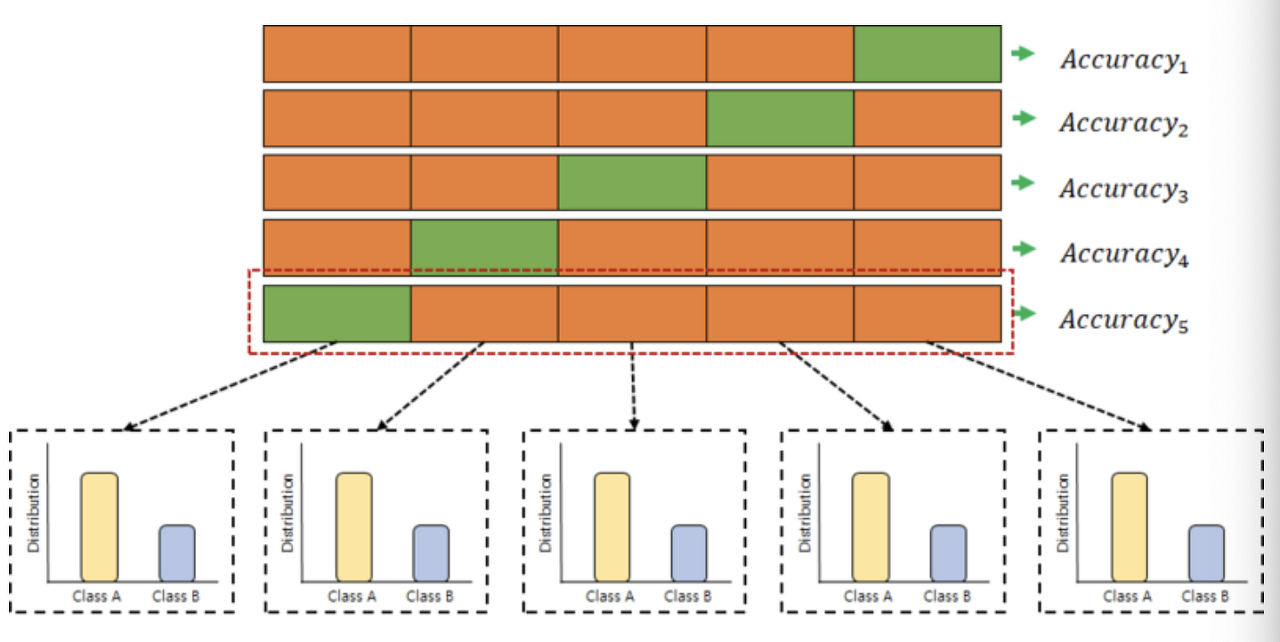

For example, in the financial transaction fraud classification model, the number of normal transactions out of the total data is 95% fraudulent, and the number of transactions is 5%. When data is divided by the general cross-validation described earlier, the number of fraudulent transactions may not be divided evenly and may be concentrated in one segment.

At this point, considering the distribution by data class, a method of creating a data fold set is layer-wise k-layer cross-validation.
Split method considering distribution by data class so that normal transactions and fraudulent transactions can be included in each data fold.

This method should be used in situations where data by data class is very unbalanced.

In [ ]:
#There are too many files, so just try 10,000. It will take too long to turn the whole things around.

# na_values to get set a list of values to be read as NaN or NA while creating DataFrame, and nrows = 10000 to make dataframe small 
print('loading files...')
train = pd.read_csv('../input/train.csv', na_values=-1, nrows =10000)  
test = pd.read_csv('../input/test.csv', na_values=-1, nrows = 10000)

In [ ]:
#Drop useless data.
col_to_drop = train.columns[train.columns.str.startswith('ps_calc_')]
train = train.drop(col_to_drop, axis=1)
test = test.drop(col_to_drop, axis=1)

In [ ]:
train.info()

In [ ]:
for c in train.select_dtypes(include=['float64']).columns:
    train[c] = train[c].astype(np.float32)
    test[c] = test[c].astype(np.float32)

for c in train.select_dtypes(include=['int64']).columns[2:]: # 왜 [2:] 하는거 노이해 
    train[c] = train[c].astype(np.int8)
    test[c] = test[c].astype(np.int8)
    
print(train.shape, test.shape)

# XGB_Parameters

You should know the parameters of the models well. If you search Google, it is shown in documentation. How to tune parameters and their meanings are shown. 

The parameters are different xgb and lgb model, but the parameters are almost the same. If you look at these, they have different names, but there are some that say the same things. You need to understand the algorithm a little to understand the meaning of these parameters. 

That's why we have to study algorithms.


#### **1) learning_rate** [default=0.3, allas: eta]: range[0,1]
* Step size shrinkage used in update to prevents overfitting. After each boosting step, we can diresctly get the weights of new features. 
* 'learning_rate' shrinks the feature weights to make the boosting process more conservative. 
*  It is easier to tune other parameters if it is set to 0.05 to 0.1 or higher. 
*  If you want fine accuracy adjustment, leave it. Once the other parameters are fixed, there is no need to change them. 
*  Also, tuning to unnecessarily long decimal places is useless.
 
#### **2) min_split_loss** [defalut=0, alas: gamma]: range[0,∞]

*  Minimum loss reduction required to make a further partition on a leaf node of the tree. 
* The larger gamma is, the more conservative the algorithm will be.
  
#### **3) max_depth** [default=6]: range: [0,∞] 
* Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
* 0 is only accepted in lossguided growing policy when tree_method is set as hist or gpu_hist and it indicates no limit on depth. 
* Beware that XGBoost aggressively consumes memory when training a deep tree.
* If set to -1, branch out without restriction. If there are many features, set it higher, and set it first when setting parameters.
 
#### **4) subsample** [default=1]: range: (0,1]
* Subsample ratio of the training instances.
* Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. 
* Subsampling will occur once in every boosting iteration.
 
#### **5) colsample_bytree** [default=1]: range (0, 1]
* It specify the fraction of columns to be subsampled.
* Increase the diversity of each column by sampling it. 
* It was a function in a random forest, usually with higher accuracy.
* 1 without column sampling is the default, but it is common to set it to 0.7 to 0.9.

### What is Gini index?
Gini index or Gini impurity measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen.

The degree of Gini index varies between 0 and 1, where 0 denotes that all elements belong to a certain class or if there exists only one class, and 1 denotes that the elements are randomly distributed across various classes. 

A Gini Index of 0.5 denotes equally distributed elements into some classes.

In [ ]:
# custom objective function (similar to auc)

def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True

## Xgb: 
**XGBoost is an Ensemble algorithm that uses a combination of several Decision trees.**
* It has excellent efficiency, flexibility, and portability.
* Flexible Learning System - You can adjust multiple parameters to create an optimal model.
* Overfitting can be prevented.
* Compared to neural networks, visualization is easier and more intuitive than understanding.
* It supports Cross validation.
* It represents high performance. More than 90% of the datasets showed higher performance than GBMs. Also, as the results of actually writing XGBoost in Kaggle began to sweep the top ranks, people began to use it, both for you and me.

Because Stacking is taught separately by dividing each fold, it is necessary to predict the value of the test test with the model from here and combine it, so if a folder with only zero is divided, it is meaningless to give it out.

In [ ]:
#xgb 
params = {'eta': 0.02, 
          'max_depth': 4,
          'subsample': 0.9,
          'colsample_bytree':0.9, #dive the fold in 0.1 : 0.9
          'objective': 'binary:logistic', #logistic the binary classifiaction 
          'eval_metric': 'auc',
          'silent': True}

X = train.drop(['id', 'target'], axis =1)
features = X.columns
X = X.values
y = train['target'].values
sub = test['id'].to_frame()
sub['target'] = 0

nrounds = 200
kfold = 2
skf = StratifiedKFold(n_splits=kfold, random_state=0, shuffle =True) #StratifiedkFold since the dataset is inbalance. 

In [ ]:
for i, (train_index, test_index) in enumerate(skf.split(X,y)): #You have to put 'y' value in to show how to divide it
    print(' xgb kfold: {} of {}: '.format(i+1,kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    d_train = xgb.DMatrix(X_train, y_train)  #xgb is a DMatrix data structure, so you have to make it if you have to make it faster.
    d_valid = xgb.DMatrix(X_valid, y_valid)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')] #watchlistis to check whether our learning is going well or not. If it's not going well, it can stop it
    xgb_model = xgb.train(params, 
                          d_train, 
                          nrounds, 
                          watchlist, 
                          early_stopping_rounds=100, #standard for 'early_stooping_rounds' to stop is to check and stop the watch list.
                          feval=gini_xgb, #Outputs a function to be executed the 'gini' values
                          maximize=True,
                          verbose_eval=100)
    
    #sub['target'] += xgb_model.predict(xgb.DMatrix(test[features].values),ntree_limit = xgb_model.best_ntree_limit+50 / (2 * kfold))
    #ntree_limit specify the value when to stop. 
    #In other words, make a prediction only 50 more rounds from the highest Gini coefficient. 
    #We gave it to Kfold here. Because it was divided into two, it was divided into four quarters because each of them made a submission.
gc.collect()
sub.head(2)

# LGB_Parameters
**The hyperparameters of lgb are similar, but because lgb uses leaf-wise algorithms, the value of the leaf-wise hyperparameters is added.** I explained the parameter that are not explained in the XGB parameter. 

**1)** **num_iterations [default=100]**: Specifies the number of trees that you want to repeat. Setting too large will result in overfitting.

**2)** **min_data_in_leaf [default=20]**: Parameters such as min_samples_leaf in the decision tree. It is used as a parameter to control overfitting.

**3)** **num_leaves [default=3]**: Indicates the maximum number of leaves a tree can have.

**4)** **bagging_fraction [default=1.0]**: Specifies the percentage at which data is sampled. Used to control overfitting.

**5)** **feature_fraction	 [default=1.0]**: The percentage of features randomly selected when learning an individual tree.

**6)** **lambda_l1**: Value for L1 regulation control.

**7)** **lambda_l2**: Value for L2 regulation control.



 ## lgb: 
####  **LightGBM is a gradient boosting framework that uses tree based learning algorithms.**

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel, distributed, and GPU learning.
* Capable of handling large-scale data.

In [ ]:
# lgb. Same code as xgb
params = {'metric': 'auc', 
          'learning_rate' : 0.01, 
          'max_depth':10, 
          'max_bin':10,  
          'objective': 'binary', 
          'feature_fraction': 0.8,
          'bagging_fraction':0.9,
          'bagging_freq':10,  
          'min_data': 500}

skf = StratifiedKFold(n_splits=kfold, random_state=1, shuffle=True)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    print(' lgb kfold: {} of {} : '.format(i+1,kfold))
    X_train, X_eval = X[train_index], X[test_index]
    y_train, y_eval = y[train_index], y[test_index]
    
    lgb_model = lgb.train(params, 
                          lgb.Dataset(X_train, label=y_train), 
                          nrounds, 
                          lgb.Dataset(X_eval, label=y_eval), 
                          verbose_eval=100, 
                          feval=gini_lgb, 
                          early_stopping_rounds=100)  
    
sub.to_csv('sub10.csv', index=False, float_format='%.5f') 
gc.collect()
sub.head(2)    
    

The target values is not appropriate since we used much less data than we should use.

# Conclusion
**XGBoost is currently the dominant algorithm for building accurate models on conventional data (also called tabular or strutured data). Go apply it to improve your models!**